# Caml API Usage

In [131]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [132]:
import os
import sys

os.environ["PYSPARK_PYTHON"] = sys.executable
os.environ["PYSPARK_DRIVER_PYTHON"] = sys.executable

datasets = [
    "partially_linear_simple",
    "fully_heterogenous",
    "partially_linear_constant",
    "dowhy_linear",
]
backends = ["pandas", "pyspark", "polars"]

df_backend = backends[0]
dataset = datasets[3]

## Synthetic Data

In [133]:
from caml.extensions.synthetic_data import (
    make_partially_linear_dataset_simple,
    make_fully_heterogeneous_dataset,
    make_partially_linear_dataset_constant,
    make_dowhy_linear_dataset,
)

if dataset == "partially_linear_simple":
    df, true_cates, true_ate = make_partially_linear_dataset_simple(
        n_obs=5000,
        n_confounders=5,
        dim_heterogeneity=2,
        binary_treatment=True,
        seed=None,
    )
    df["true_cates"] = true_cates
elif dataset == "fully_heterogenous":
    df, true_cates, true_ate = make_fully_heterogeneous_dataset(
        n_obs=10_000,
        n_confounders=10,
        theta=4.0,
        seed=None,
    )
    df["true_cates"] = true_cates
elif dataset == "partially_linear_constant":
    df, true_cates, true_ate = make_partially_linear_dataset_constant(
        n_obs=5000,
        ate=4.0,
        n_confounders=5,
        dgp="make_plr_CCDDHNR2018",  # make_plr_turrell2018
        seed=None,
    )
    df["true_cates"] = true_cates
elif dataset == "dowhy_linear":
    df, true_cates, true_ate = make_dowhy_linear_dataset(
        beta=2.0,
        n_obs=10_000,
        n_confounders=10,
        n_discrete_confounders=3,
        n_effect_modifiers=10,
        n_discrete_effect_modifiers=3,
        n_treatments=1,
        binary_treatment=True,
        categorical_treatment=False,
        binary_outcome=False,
        seed=12,
    )

    for i in range(1, len(true_cates) + 1):
        if isinstance(true_cates[f"d{i}"], list):
            df[f"true_cate_d{i}_1"] = true_cates[f"d{i}"][0]
            df[f"true_cate_d{i}_2"] = true_cates[f"d{i}"][1]
        else:
            df[f"true_cate_d{i}"] = true_cates[f"d{i}"]


df["uuid"] = df.index

In [134]:
try:
    import polars as pl
    from pyspark.sql import SparkSession
except ImportError:
    pass

if df_backend == "polars":
    df = pl.from_pandas(df)
    spark = None
elif df_backend == "pandas":
    spark = None
    pass
elif df_backend == "pyspark":
    spark = (
        SparkSession.builder.master("local[1]")
        .appName("local-tests")
        .config("spark.executor.cores", "1")
        .config("spark.executor.instances", "1")
        .config("spark.sql.shuffle.partitions", "1")
        .getOrCreate()
    )
    df = spark.createDataFrame(df)

In [135]:
df

,X0,X1,X2,X3,X4,X5,X6,X7,X8,X9,...,W4,W5,W6,W7,W8,W9,d1,y,true_cate_d1,uuid
0,0.860128,1.263800,-1.621480,-1.243014,0.119318,0.138299,-2.190976,3,0,2,...,-1.777832,3.709313,0.203607,2,3,0,True,4.197980,0.793035,0
1,0.085828,-0.258028,0.648743,-1.045765,-0.128647,0.435518,0.108749,3,0,2,...,-2.000380,2.047290,1.303302,2,2,2,True,8.774372,5.340261,1
2,1.077397,-0.389245,0.503995,-1.182757,-1.419884,1.466198,-1.111965,3,3,2,...,-3.189385,0.190063,0.273025,1,2,1,False,-6.610495,7.983276,2
3,1.864333,0.424140,0.705238,1.087511,-0.978616,1.553906,-1.056368,1,3,0,...,-0.935434,0.159549,0.229549,1,3,2,True,8.211690,10.040109,3
4,0.042030,-2.178140,0.773407,-1.260931,0.600929,0.659652,-0.311650,0,3,0,...,-4.118267,1.372630,1.033920,3,0,3,True,3.598249,4.030683,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,1.173214,1.718103,0.527236,-0.833312,0.857061,-0.963238,-0.802704,0,2,2,...,1.446361,0.877547,0.160547,0,1,1,True,10.896206,6.942622,9995
9996,0.916397,0.691821,0.512401,-0.098800,-0.721480,0.789828,0.042103,2,2,2,...,-1.341384,-0.574287,2.923056,2,2,1,True,10.268397,9.750975,9996
9997,3.512478,-0.894800,1.119166,-1.482994,-1.278946,-0.029847,-0.221000,3,3,2,...,-1.698003,1.961363,0.020335,2,1,2,True,11.488667,11.082038,9997
9998,0.615903,1.969203,0.407985,0.945009,0.580888,0.783290,-1.168335,1,3,2,...,-2.156037,1.078907,1.013377,2,0,3,True,12.162188,11.152002,9998


In [140]:
from caml.extensions.synthetic_data import CamlSyntheticDataGenerator

data = CamlSyntheticDataGenerator(n_obs=10_000,
                                  n_cont_outcomes=1,
                                  n_binary_outcomes=0,
                                  n_cont_treatments=0,
                                  n_binary_treatments=0,
                                  n_discrete_treatments=1,
                                  n_cont_confounders=4, 
                                  n_binary_confounders=2,
                                  n_discrete_confounders=2,
                                  n_cont_heterogeneity_covariates=4,
                                  n_binary_heterogeneity_covariates=2,
                                  n_discrete_heterogeneity_covariates=2,
                                  n_heterogeneity_confounders=0,
                                  stddev_outcome_noise=0,
                                  stddev_treatment_noise=0,
                                  causal_model_functional_form="fully_linear",
                                  seed=None)

synthetic_df, cate_df, ate_df = data()

df = synthetic_df.copy()

df

,W1_continuous,W2_continuous,W3_continuous,W4_continuous,W1_binary,W2_binary,W1_discrete,W2_discrete,X1_continuous,X2_continuous,X3_continuous,X4_continuous,X1_binary,X2_binary,X1_discrete,X2_discrete,T1_discrete,Y1_continuous
0,5.293037,1.113482,-4.182994,6.885456,0,1,2,3,-3.688246,3.596969,-6.717900,4.935438,1,1,1,3,1,-21.295247
1,4.326464,0.189764,-5.775590,21.236460,0,0,6,2,-4.990189,3.776836,-6.044803,-0.411878,1,1,0,1,1,-19.552741
2,1.213532,1.398921,-4.262518,0.946626,1,0,3,1,-3.085626,11.180449,-6.056958,-1.064351,1,0,4,1,0,10.762048
3,5.120986,0.526217,-2.140702,0.803041,0,1,6,3,-2.432333,2.827889,-5.694313,10.078837,1,0,1,1,0,-23.964825
4,2.863003,0.806965,-6.337129,1.903664,0,1,5,1,-3.431923,2.229102,-4.509410,0.996590,1,1,1,1,0,-1.027188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9.055994,1.843684,-2.174204,3.127281,1,1,3,1,-3.133360,0.761653,-4.301373,3.416383,1,0,1,1,0,-4.717365
9996,2.014413,1.973248,-7.021922,3.337783,0,0,6,1,-3.266050,1.786295,-5.943833,4.106626,0,1,0,1,1,-4.874772
9997,2.550432,1.970975,-8.463572,0.593608,1,1,4,4,-3.830940,7.950603,-4.810508,3.695341,0,1,2,0,0,5.771500
9998,2.569031,0.387064,-4.928740,2.962002,0,1,5,5,-2.630579,0.862013,-2.659435,8.370430,0,0,1,0,0,-17.676994


## Core API

### CamlCATE

#### Class Instantiation

In [141]:
from caml import CamlCATE

caml = CamlCATE(
    df=df,
    Y="Y1_continuous",
    T="T1_discrete",
    X=[c for c in df.columns if "X" in c or "W" in c],
    W=[],
    discrete_treatment=True,
    discrete_outcome=False,
    seed=10,
    verbose=1,
)

[12/15/24 00:36:28] INFO     Logging has been set up.                                                 ]8;id=323174;file:///home/jakep/projects/caml/caml/logging.py\logging.py]8;;\:]8;id=723724;file:///home/jakep/projects/caml/caml/logging.py#51\51]8;;\

In [142]:
print(caml)

================== CamlCATE Object ==================
Data Backend: pandas
No. of Observations: 10,000
Outcome Variable: Y1_continuous
Discrete Outcome: False
Treatment Variable: T1_discrete
Discrete Treatment: True
Features/Confounders for Heterogeneity (X): ['W1_continuous', 'W2_continuous', 'W3_continuous', 'W4_continuous', 'W1_binary', 'W2_binary', 'W1_discrete', 'W2_discrete', 'X1_continuous', 'X2_continuous', 'X3_continuous', 'X4_continuous', 'X1_binary', 'X2_binary', 'X1_discrete', 'X2_discrete']
Features/Confounders as Controls (W): []
Random Seed: 10



#### Nuissance Function AutoML

In [143]:
caml.auto_nuisance_functions(
    flaml_Y_kwargs={"time_budget": 30,"verbose":0},
    flaml_T_kwargs={"time_budget": 30,"verbose":0},
    use_ray=False,
    use_spark=False,
)

#### Fit and ensemble CATE models

In [145]:
caml.fit_validator(
    subset_cate_models=[
        "LinearDML",
        "CausalForestDML",
        # "NonParamDML",
        # "AutoNonParamDML",
        # "SparseLinearDML-2D",
        "DRLearner",
        "ForestDRLearner",
        "LinearDRLearner",
        # "SparseLinearDRLearner-2D",
        "DomainAdaptationLearner",
        "SLearner",
        "TLearner",
        "XLearner"
    ],
    rscorer_kwargs={},
    use_ray=False,
    ray_remote_func_options_kwargs={},
    sample_fraction=1.0,
    n_jobs=-1,
)

[12/15/24 00:38:50] INFO     Ensemble Estimator RScore: 0.2973673396706974                              ]8;id=524905;file:///home/jakep/projects/caml/caml/core/cate.py\cate.py]8;;\:]8;id=517092;file:///home/jakep/projects/caml/caml/core/cate.py#734\734]8;;\

                    INFO     Inidividual Estimator RScores: {'LinearDML': 0.2973673396706974,           ]8;id=811171;file:///home/jakep/projects/caml/caml/core/cate.py\cate.py]8;;\:]8;id=483537;file:///home/jakep/projects/caml/caml/core/cate.py#735\735]8;;\
                             'CausalForestDML': 0.2009136131888155, 'DRLearner': 0.21785888075656523,              
                             'ForestDRLearner': 0.2026401314608668, 'LinearDRLearner':                             
                             0.23889803023024403, 'DomainAdaptationLearner': 0.23761890155610232,                  
                             'SLearner': 0.2062625729502915, 'TLearner': 0.20666685106068428,                      
                             'XLearner': 0.20107522161915936}                                                      

                    INFO     The best estimator is greater than the ensemble estimator. Returning that  ]8;id=715471;file:///home/jakep/projects/caml/caml/core/cate.py\cate.py]8;;\:]8;id=528828;file:///home/jakep/projects/caml/caml/core/cate.py#747\747]8;;\
                             individual estimator: <econml.dml.dml.LinearDML object at 0x7f82d425e800>             

In [146]:
caml.validation_estimator

[12/15/24 00:38:53] INFO     The validation estimator has been fit and will be returned.                ]8;id=794015;file:///home/jakep/projects/caml/caml/core/_base.py\_base.py]8;;\:]8;id=492219;file:///home/jakep/projects/caml/caml/core/_base.py#61\61]8;;\

#### CATE Validation

[12/15/24 00:38:58] INFO     All validation results suggest that the model has found statistically      ]8;id=596353;file:///home/jakep/projects/caml/caml/core/cate.py\cate.py]8;;\:]8;id=559321;file:///home/jakep/projects/caml/caml/core/cate.py#472\472]8;;\
                             significant heterogeneity.                                                            

   treatment  blp_est  blp_se  blp_pval  qini_est  qini_se  qini_pval  autoc_est  autoc_se  autoc_pval  cal_r_squared
0          1    0.583   0.050       0.0     1.621    0.095        0.0      4.176     0.238         0.0         -0.117
1          2    0.589   0.017       0.0     3.489    0.117        0.0      9.021     0.315         0.0         -0.015
2          3    0.723   0.038       0.0     5.598    0.213        0.0     13.867     0.530         0.0          0.537


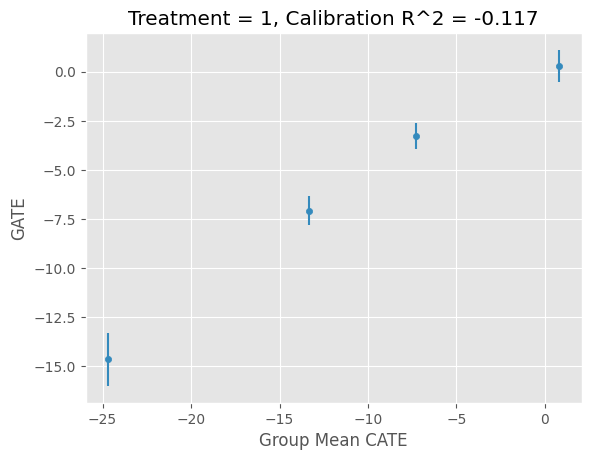

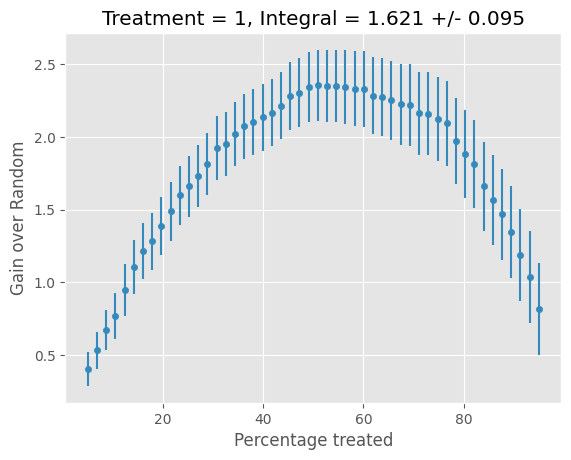

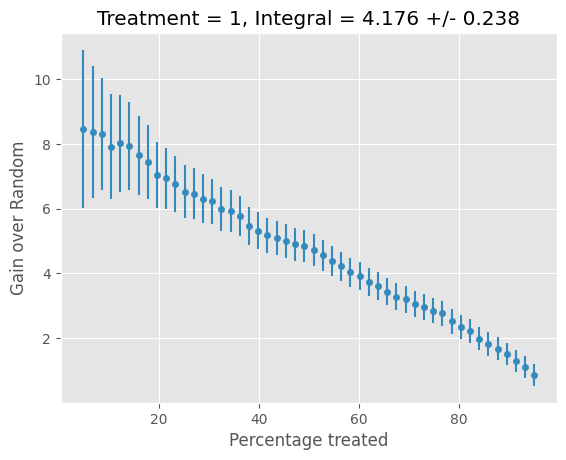

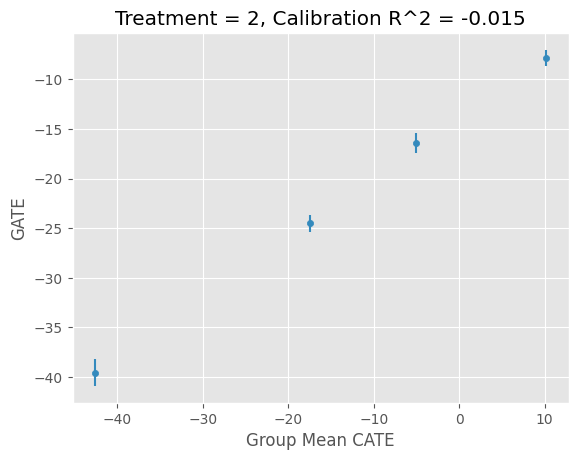

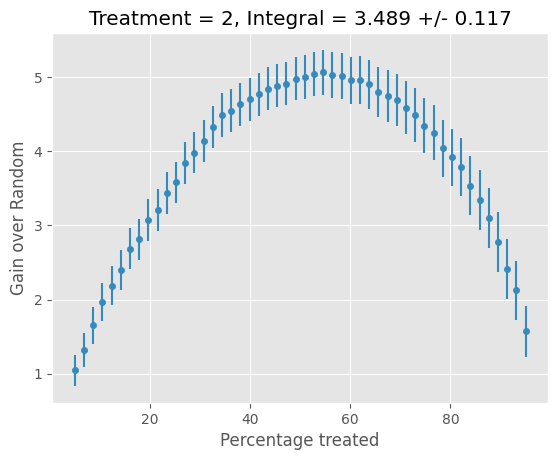

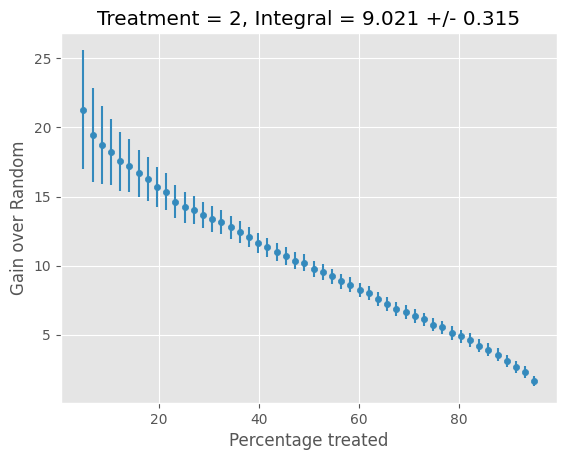

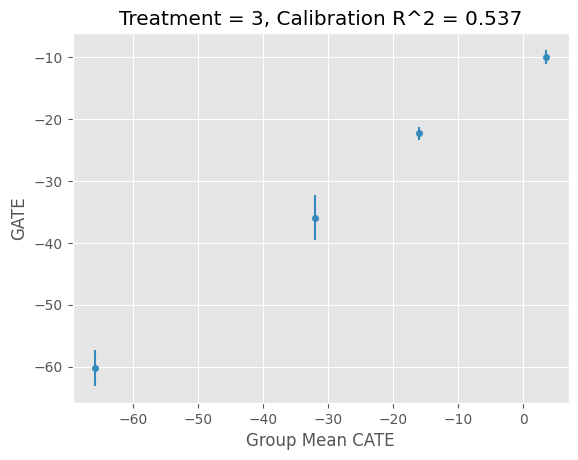

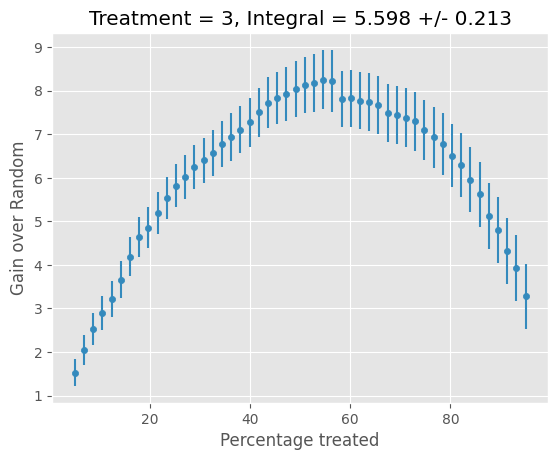

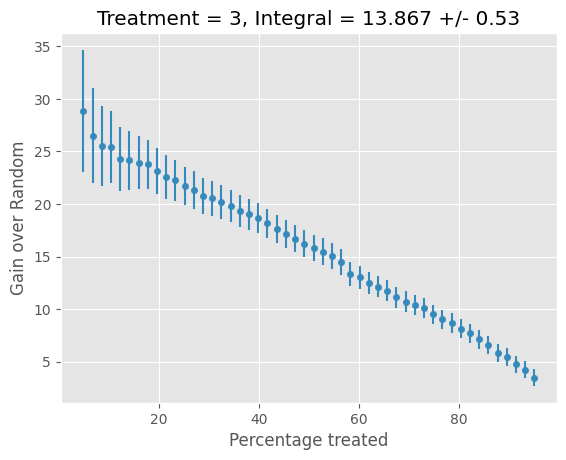

In [147]:
validation_results = caml.validate(n_groups=4,n_bootstrap=1000,print_full_report=True)

#### Refit best estimator on full dataset

In [148]:
caml.fit_final()

In [149]:
caml.final_estimator

[12/15/24 00:39:27] INFO     The final estimator has been fit on the entire dataset and will be         ]8;id=24212;file:///home/jakep/projects/caml/caml/core/_base.py\_base.py]8;;\:]8;id=151682;file:///home/jakep/projects/caml/caml/core/_base.py#71\71]8;;\
                             returned.                                                                             

#### Predict CATEs

In [155]:
## "Out of sample" predictions

cate_predictions = caml.predict(T0=0,T1=3)

cate_predictions

array([ -45.33280736,  -29.89351346, -142.5631791 , ...,  -75.33255451,
          4.10979119,  -36.30898076])

#### CATE Visualization/Summary

In [158]:
cate_summary = caml.summarize()

cate_summary

,cate_predictions_0_1,cate_predictions_0_2,cate_predictions_0_3
count,10000.000000,10000.000000,10000.000000
mean,-10.950006,-14.514957,-24.864787
std,9.272427,20.820196,28.053457
min,-78.906940,-188.887377,-248.412578
25%,-16.176586,-25.797198,-39.977700
50%,-9.936424,-11.869597,-20.848476
75%,-4.772324,-0.476332,-5.620950
max,22.843666,53.824127,52.859046


In [159]:
ate_df

,Treatment,ATE
0,T1_discrete_on_Y1_continuous_level_1_v_0,-9.780627
1,T1_discrete_on_Y1_continuous_level_2_v_0,-19.561254
2,T1_discrete_on_Y1_continuous_level_3_v_0,-29.341880


#### Access my dataframe, estimator object, and get string representation of class

In [160]:
caml.df

,W1_continuous,W2_continuous,W3_continuous,W4_continuous,W1_binary,W2_binary,W1_discrete,W2_discrete,X1_continuous,X2_continuous,X3_continuous,X4_continuous,X1_binary,X2_binary,X1_discrete,X2_discrete,T1_discrete,Y1_continuous
0,5.293037,1.113482,-4.182994,6.885456,0,1,2,3,-3.688246,3.596969,-6.717900,4.935438,1,1,1,3,1,-21.295247
1,4.326464,0.189764,-5.775590,21.236460,0,0,6,2,-4.990189,3.776836,-6.044803,-0.411878,1,1,0,1,1,-19.552741
2,1.213532,1.398921,-4.262518,0.946626,1,0,3,1,-3.085626,11.180449,-6.056958,-1.064351,1,0,4,1,0,10.762048
3,5.120986,0.526217,-2.140702,0.803041,0,1,6,3,-2.432333,2.827889,-5.694313,10.078837,1,0,1,1,0,-23.964825
4,2.863003,0.806965,-6.337129,1.903664,0,1,5,1,-3.431923,2.229102,-4.509410,0.996590,1,1,1,1,0,-1.027188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9.055994,1.843684,-2.174204,3.127281,1,1,3,1,-3.133360,0.761653,-4.301373,3.416383,1,0,1,1,0,-4.717365
9996,2.014413,1.973248,-7.021922,3.337783,0,0,6,1,-3.266050,1.786295,-5.943833,4.106626,0,1,0,1,1,-4.874772
9997,2.550432,1.970975,-8.463572,0.593608,1,1,4,4,-3.830940,7.950603,-4.810508,3.695341,0,1,2,0,0,5.771500
9998,2.569031,0.387064,-4.928740,2.962002,0,1,5,5,-2.630579,0.862013,-2.659435,8.370430,0,0,1,0,0,-17.676994


In [161]:
from econml.score import EnsembleCateEstimator

# Use this estimator object as pickled object for optimized inference
final_estimator = caml.final_estimator

if isinstance(final_estimator, EnsembleCateEstimator):
    for mod in final_estimator._cate_models:
        print(mod)
        print(mod._input_names)
else:
    print(final_estimator)
    print(final_estimator._input_names)

[12/15/24 00:40:14] INFO     The final estimator has been fit on the entire dataset and will be         ]8;id=370253;file:///home/jakep/projects/caml/caml/core/_base.py\_base.py]8;;\:]8;id=434778;file:///home/jakep/projects/caml/caml/core/_base.py#71\71]8;;\
                             returned.                                                                             

{'feature_names': ['W1_continuous', 'W2_continuous', 'W3_continuous', 'W4_continuous', 'W1_binary', 'W2_binary', 'W1_discrete', 'W2_discrete', 'X1_continuous', 'X2_continuous', 'X3_continuous', 'X4_continuous', 'X1_binary', 'X2_binary', 'X1_discrete', 'X2_discrete'], 'output_names': 'Y1_continuous', 'treatment_names': 'T1_discrete'}


In [163]:
print(caml)

================== CamlCATE Object ==================
Data Backend: pandas
No. of Observations: 10,000
Outcome Variable: Y1_continuous
Discrete Outcome: False
Treatment Variable: T1_discrete
Discrete Treatment: True
Features/Confounders for Heterogeneity (X): ['W1_continuous', 'W2_continuous', 'W3_continuous', 'W4_continuous', 'W1_binary', 'W2_binary', 'W1_discrete', 'W2_discrete', 'X1_continuous', 'X2_continuous', 'X3_continuous', 'X4_continuous', 'X1_binary', 'X2_binary', 'X1_discrete', 'X2_discrete']
Features/Confounders as Controls (W): []
Random Seed: 10
Nuissance Model Y_X: RandomForestRegressor(max_features=0.9142769976809394, max_leaf_nodes=2990,
                      n_estimators=76, n_jobs=-1, random_state=12032022)
Propensity/Nuissance Model T_X: RandomForestClassifier(criterion='entropy', max_features=0.5953282851219257,
                       max_leaf_nodes=325, n_estimators=115, n_jobs=-1,
                       random_state=12032022)
Regression Model Y_X_T: RandomForestR

In [164]:
df

,W1_continuous,W2_continuous,W3_continuous,W4_continuous,W1_binary,W2_binary,W1_discrete,W2_discrete,X1_continuous,X2_continuous,X3_continuous,X4_continuous,X1_binary,X2_binary,X1_discrete,X2_discrete,T1_discrete,Y1_continuous
0,5.293037,1.113482,-4.182994,6.885456,0,1,2,3,-3.688246,3.596969,-6.717900,4.935438,1,1,1,3,1,-21.295247
1,4.326464,0.189764,-5.775590,21.236460,0,0,6,2,-4.990189,3.776836,-6.044803,-0.411878,1,1,0,1,1,-19.552741
2,1.213532,1.398921,-4.262518,0.946626,1,0,3,1,-3.085626,11.180449,-6.056958,-1.064351,1,0,4,1,0,10.762048
3,5.120986,0.526217,-2.140702,0.803041,0,1,6,3,-2.432333,2.827889,-5.694313,10.078837,1,0,1,1,0,-23.964825
4,2.863003,0.806965,-6.337129,1.903664,0,1,5,1,-3.431923,2.229102,-4.509410,0.996590,1,1,1,1,0,-1.027188
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9.055994,1.843684,-2.174204,3.127281,1,1,3,1,-3.133360,0.761653,-4.301373,3.416383,1,0,1,1,0,-4.717365
9996,2.014413,1.973248,-7.021922,3.337783,0,0,6,1,-3.266050,1.786295,-5.943833,4.106626,0,1,0,1,1,-4.874772
9997,2.550432,1.970975,-8.463572,0.593608,1,1,4,4,-3.830940,7.950603,-4.810508,3.695341,0,1,2,0,0,5.771500
9998,2.569031,0.387064,-4.928740,2.962002,0,1,5,5,-2.630579,0.862013,-2.659435,8.370430,0,0,1,0,0,-17.676994


# Plots

In [166]:
cate_df

,CATE_of_T1_discrete_on_Y1_continuous_level_1_v_0,CATE_of_T1_discrete_on_Y1_continuous_level_2_v_0,CATE_of_T1_discrete_on_Y1_continuous_level_3_v_0
0,-13.536187,-27.072375,-40.608562
1,-8.355341,-16.710683,-25.066024
2,-44.959351,-89.918702,-134.878054
3,-9.081233,-18.162465,-27.243698
4,-8.984975,-17.969950,-26.954926
...,...,...,...
9995,-3.183106,-6.366212,-9.549318
9996,-3.615188,-7.230376,-10.845564
9997,-24.884598,-49.769196,-74.653794
9998,-0.043062,-0.086123,-0.129185


In [168]:
from caml.extensions.plots import (cate_histogram_plot, 
                                   cate_true_vs_estimated_plot, 
                                   cate_line_plot)

df['cate_predictions'] = cate_predictions
df['true_cates'] = cate_df.iloc[:,2]

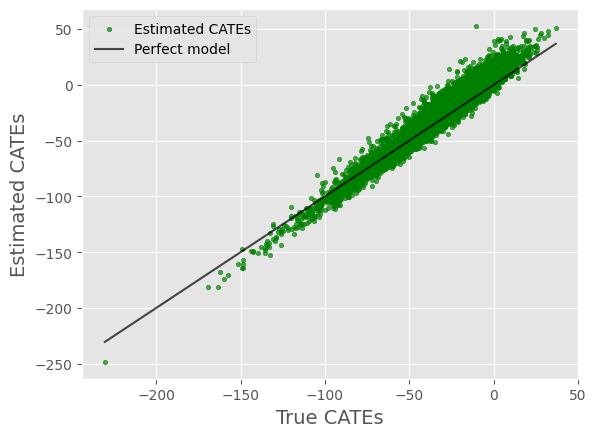

In [169]:
cate_true_vs_estimated_plot(true_cates=df['true_cates'],estimated_cates=df['cate_predictions'])

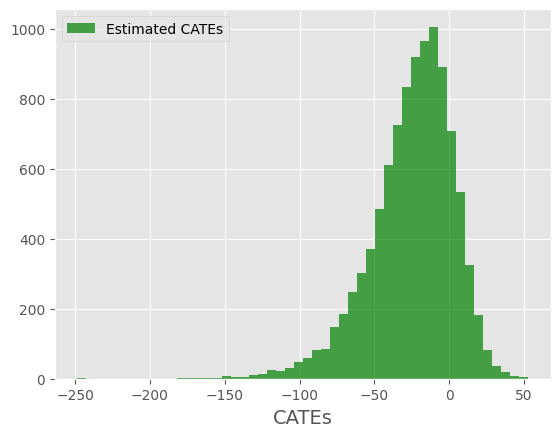

In [170]:
cate_histogram_plot(estimated_cates=df['cate_predictions'])

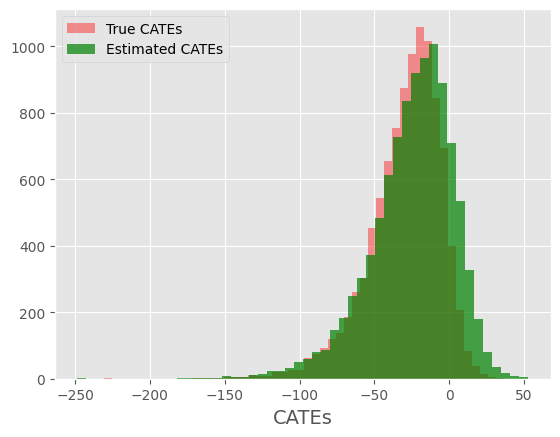

In [171]:
cate_histogram_plot(estimated_cates=df['cate_predictions'],true_cates=df['true_cates'])

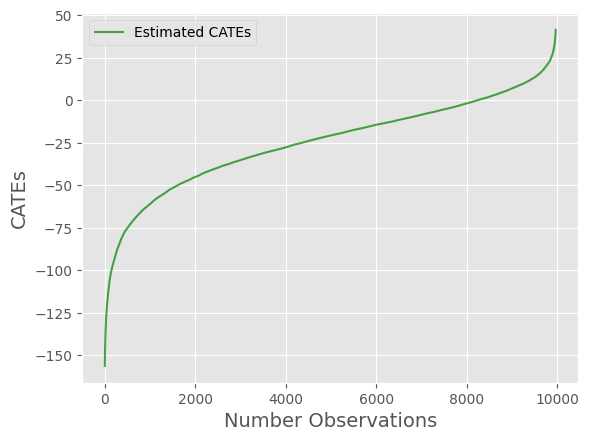

In [172]:
cate_line_plot(estimated_cates=df['cate_predictions'],window=30)

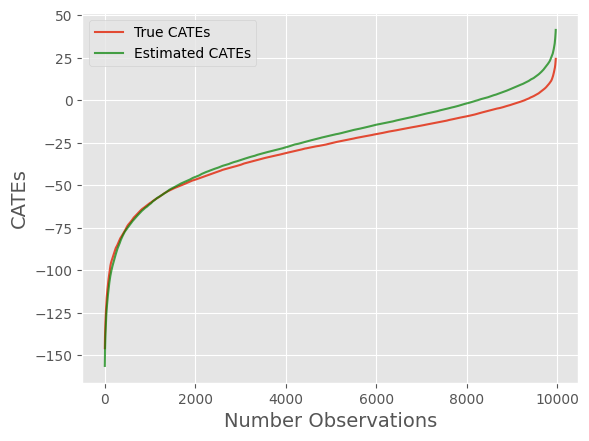

In [173]:
cate_line_plot(estimated_cates=df['cate_predictions'],true_cates=df['true_cates'],window=30)